# Here is an example for generating traveltimes (Pyekfmm) using GeoFWI

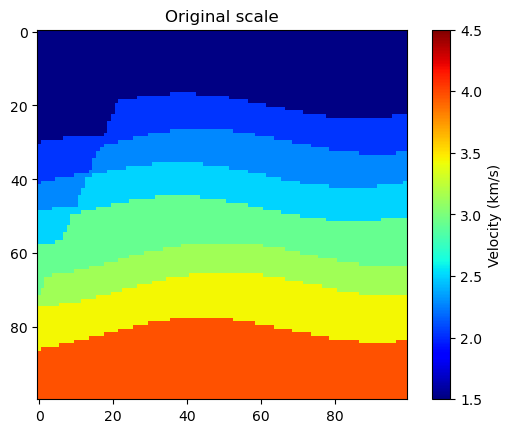

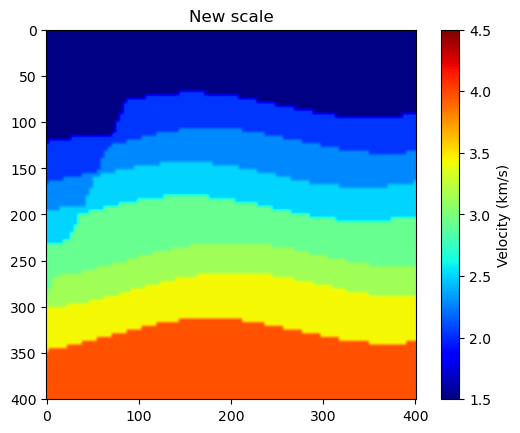

In [1]:
# !pip install git+https://github.com/aaspip/pyekfmm

import os
import numpy as np 
from scipy import interpolate
import matplotlib.pyplot as plt
from geofwi import get_vel
import warnings
warnings.simplefilter("ignore")

# import library
def numerical_traveltime2d_pykonal(vel, nx, nz, ns, xmin, zmin, deltax, deltaz, id_sou_x, id_sou_z):
    
    import pykonal

    T_data_surf = np.zeros((nz,nx,ns))

    for i in range(ns):

        solver = pykonal.EikonalSolver(coord_sys="cartesian")
        solver.velocity.min_coords = zmin, xmin, zmin
        solver.velocity.node_intervals = deltaz, deltax, deltaz
        solver.velocity.npts = nz, nx, 1
        solver.velocity.values = vel.reshape(nz,nx,1)

        src_idx = id_sou_z[i], id_sou_x[i], 0
        
        solver.traveltime.values[src_idx] = 0
        solver.unknown[src_idx] = False
        solver.trial.push(*src_idx)

        solver.solve()

        teik = solver.traveltime.values

        T_data_surf[:,:,i] = teik[:,:,0]
    
    return T_data_surf

def numerical_traveltime2d_pyekfmm(vel, nx, nz, ns, xmin, zmin, deltax, deltaz, id_sou_x, id_sou_z):
    '''
    INPUT
    vel: 2D velocity (zx)

    OUTPUT
    T_data_surf: output traveltime fields of different sources (zx)
    '''
    
    import pyekfmm as fmm
    
    T_data_surf = np.zeros((nz,nx,ns))
    
    velxz=np.transpose(vel,[1,0]) #put X the first dimension, always for pyefkmm
                       
    for i in range(ns):         
        t=fmm.eikonal(velxz,xyz=np.array([xmin+deltax*id_sou_x[i],0,zmin+deltaz*id_sou_z[i]]),ax=[xmin,deltax,nx],ay=[0,0.05,1],az=[zmin,deltaz,nz],order=2);
        teik=t.reshape(nx,nz,order='F');#first axis (vertical) is x, second is z
        T_data_surf[:,:,i] = np.transpose(teik[:,:],[1,0]) #from XZ to ZX
    
    return T_data_surf
    
## define the calculation space
zmin = 0; zmax = 5-0.05; deltaz = 0.05;
xmin = 0.; xmax = 5-0.05; deltax = 0.05;

z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size


vel=get_vel(layer=8,mode='fault',datapath='../data/',indx=20)/1000.0;

plt.imshow(vel,clim=[1.5,4.5],cmap=plt.jet());plt.colorbar(label='Velocity (km/s)');plt.title('Original scale');plt.show()

x1 = np.linspace(0, 5, nx)
z1 = np.linspace(0, 5, nz) 
x2 = np.linspace(0, 5, 4*nx+1)
z2 = np.linspace(0, 5, 4*nz+1) 
f = interpolate.interp2d (x1, z1, vel)
vel = f(x2, z2)

#The original space is
# Z: 0-5 km, nz=100
# X: 0-5 km, nx=100

#The new space is
# Z: 0-5 km, nz=401
# X: 0-5 km, nx=401


plt.imshow(vel,clim=[1.5,4.5],cmap=plt.jet());plt.colorbar(label='Velocity (km/s)');plt.title('New scale');plt.show()



In [2]:
id_sou_x=np.array([  0,  40,  80, 120, 160, 200, 240, 280]);
id_sou_z=np.array([5, 5, 5, 5, 5, 5, 5, 5]);

id_rec_x=np.array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280])
id_rec_z=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

T_data0 = numerical_traveltime2d_pykonal(vel, len(x2), len(z2), len(id_sou_x), 0, 0, x2[2]-x2[1], z2[2]-z2[1], id_sou_x, id_sou_z)
T_data = numerical_traveltime2d_pyekfmm(vel, len(x2), len(z2), len(id_sou_x), 0, 0, x2[2]-x2[1], z2[2]-z2[1], id_sou_x, id_sou_z)

T_data.shape


(401, 401, 8)

In [3]:
T_data0.max()

3.2858233829028336

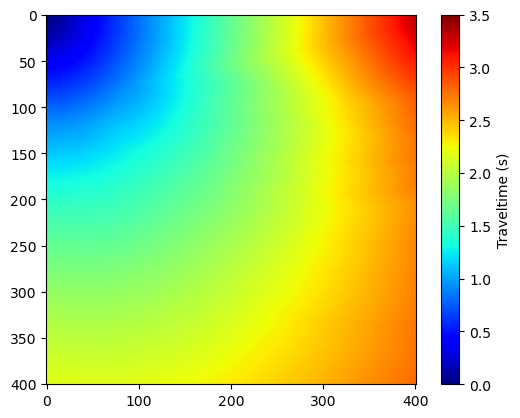

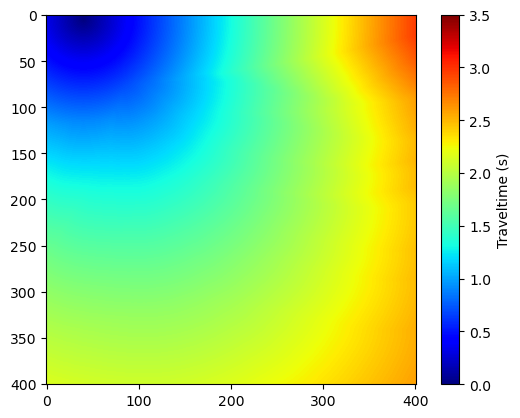

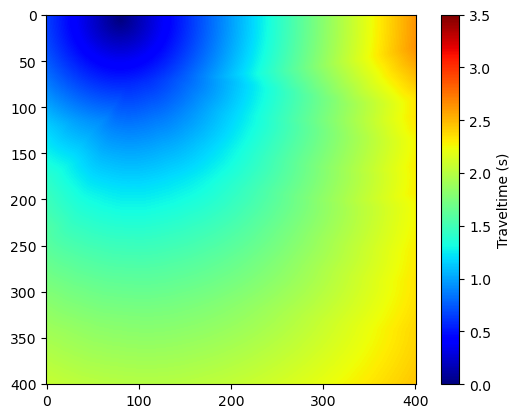

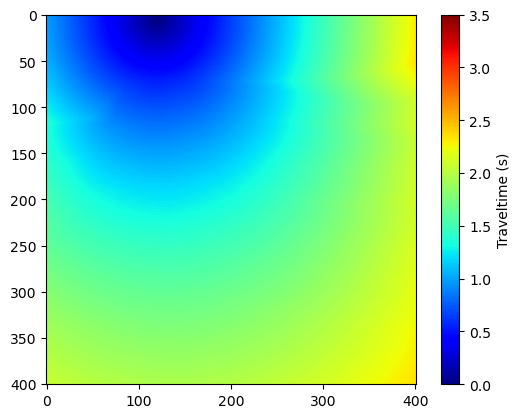

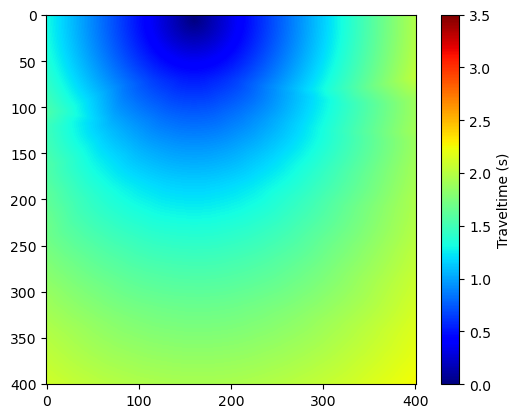

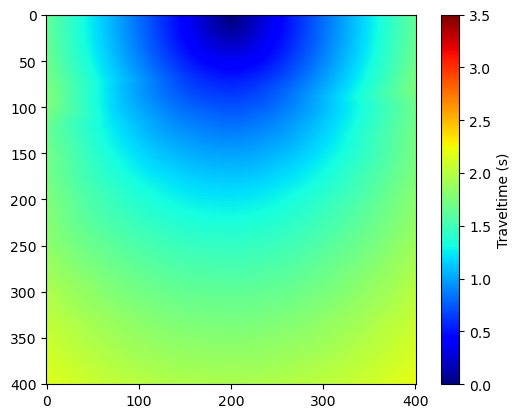

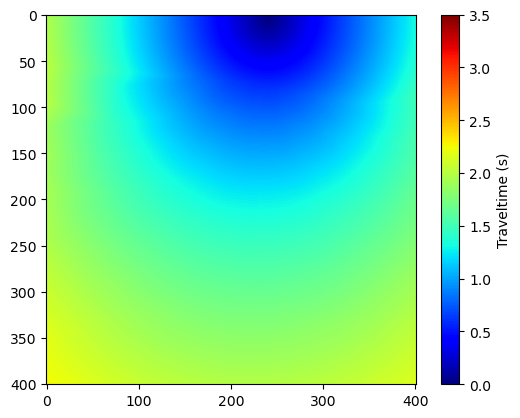

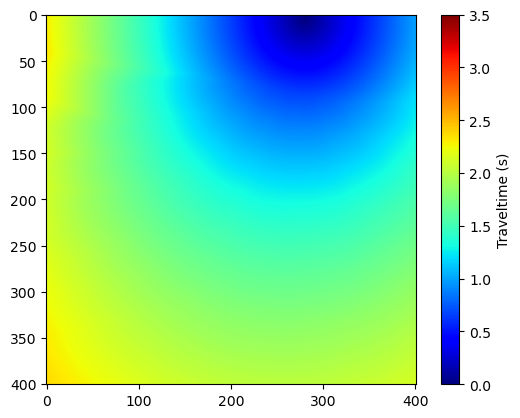

In [4]:
# Pykonal travel times
for ii in range(T_data.shape[2]):
    plt.imshow(T_data0[:,:,ii],clim=[0,3.5], cmap=plt.jet());plt.colorbar(label='Traveltime (s)');
    plt.show()

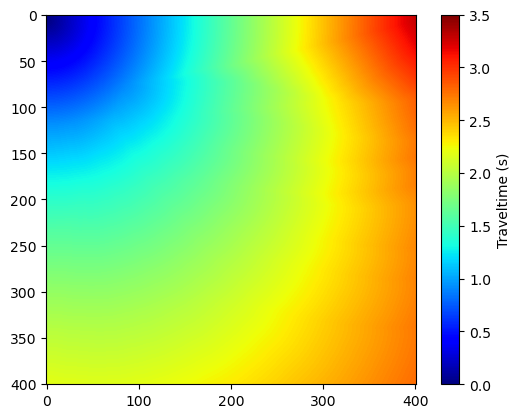

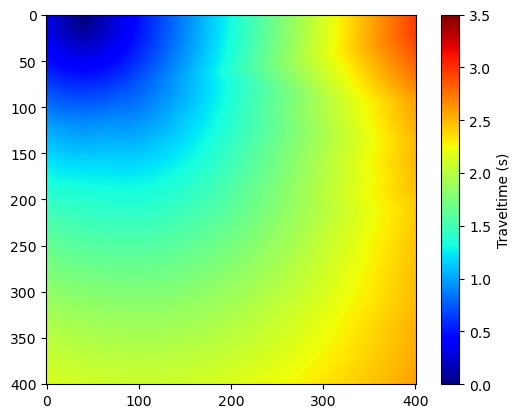

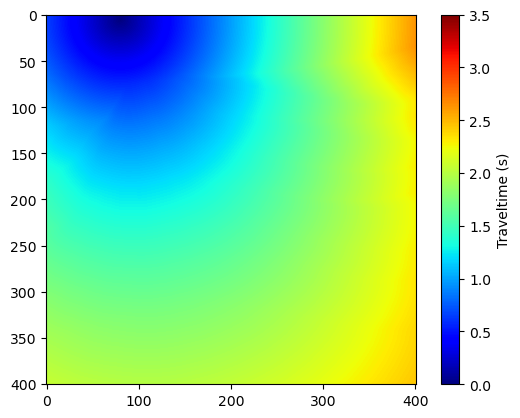

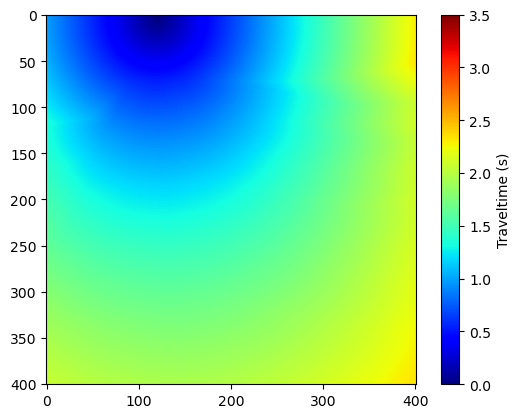

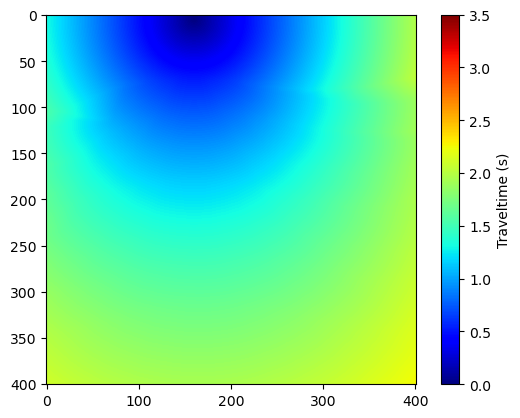

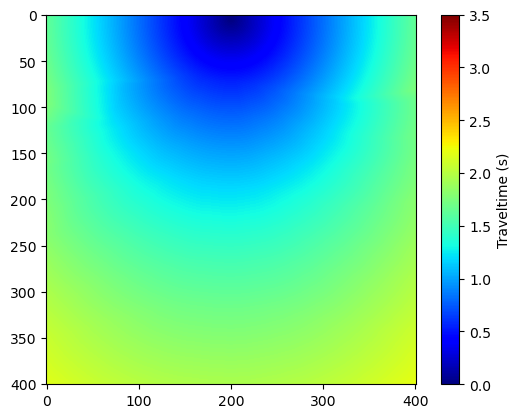

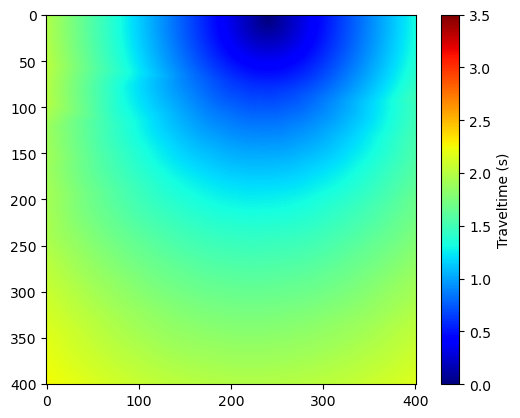

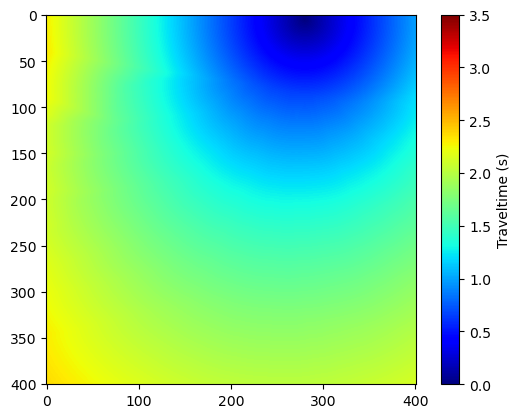

In [5]:
# Pyekfmm travel times

for ii in range(T_data.shape[2]):
    plt.imshow(T_data[:,:,ii],clim=[0,3.5], cmap=plt.jet());plt.colorbar(label='Traveltime (s)');
    plt.show()

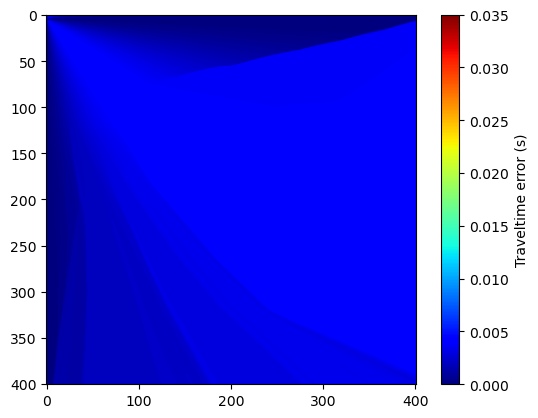

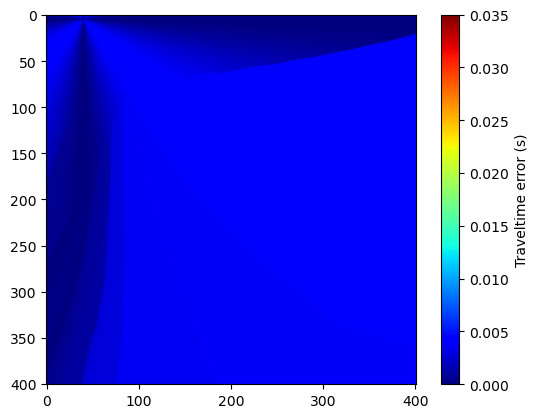

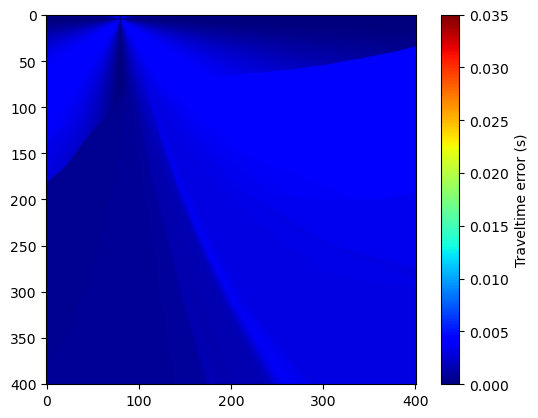

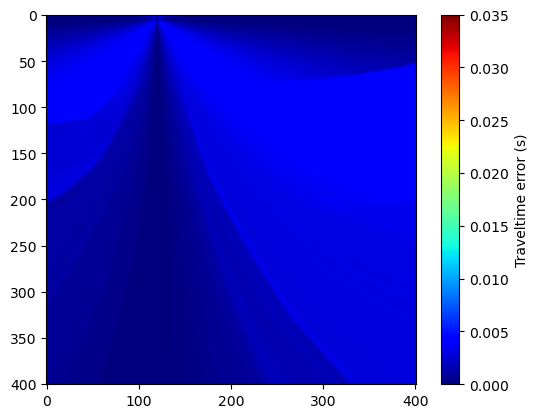

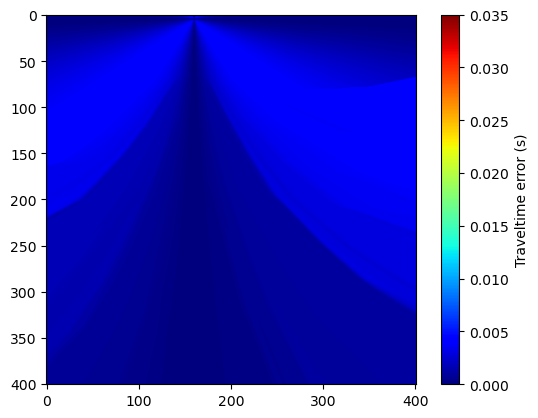

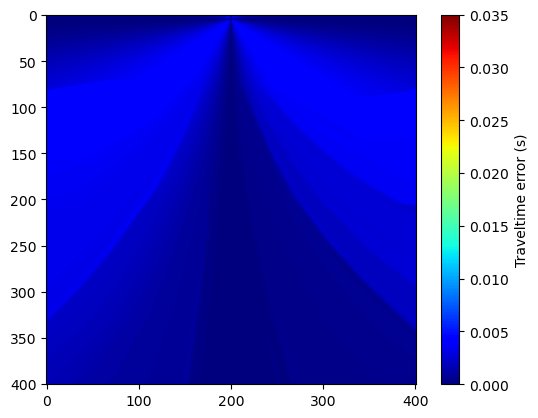

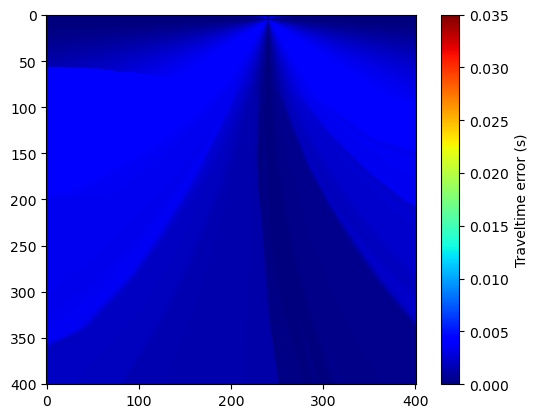

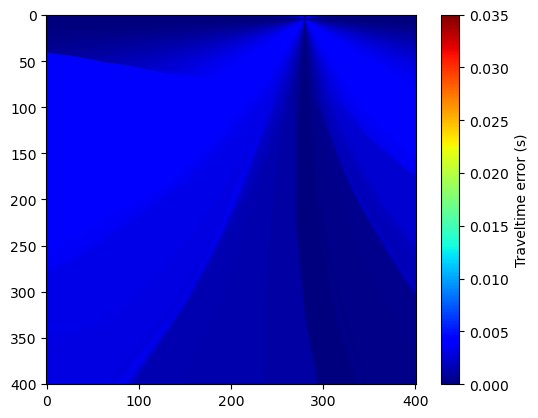

In [6]:
# Pykonal and Pyekfmm travel time difference plots

for ii in range(T_data.shape[2]):
    plt.imshow(np.abs(T_data0[:,:,ii]-T_data[:,:,ii]),clim=np.array([0,3.5])*0.01, cmap=plt.jet());plt.colorbar(label='Traveltime error (s)');
    plt.show()